### EOFs-LSTM

In [3]:
#  ------------------ import necessary packages
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#  ------------------ load training and test sets 
path_to_X_train = 'X_train.npy'
path_to_X_test = 'X_valid.npy'

path_to_Y_train = 'Y_train.npy'
path_to_Y_test = 'Y_valid.npy'

d_X_train = np.load(path_to_X_train, allow_pickle=True)
d_X_test = np.load(path_to_X_test, allow_pickle=True)

d_Y_train = np.load(path_to_Y_train, allow_pickle=True)
d_Y_test = np.load(path_to_Y_test, allow_pickle=True)

In [5]:
print(d_X_train.shape)
print(d_X_test.shape)

print(d_Y_train.shape)
print(d_Y_test.shape)

(2700, 64, 96, 12)
(300, 64, 96, 12)
(2700, 12)
(300, 12)


In [6]:
d_X_train = np.transpose(d_X_train, (0,3,1,2))
d_X_train.shape

d_X_test = np.transpose(d_X_test, (0,3,1,2))
d_X_test.shape

(300, 12, 64, 96)

In [7]:
X_train_reshape = np.reshape(d_X_train, (2700*12, 64*96))
print(X_train_reshape.shape)

X_train_smaller = X_train_reshape[:,:]
Y_train_smaller = d_Y_train[:,1]
print(X_train_smaller.shape)
print(Y_train_smaller.shape)

print('')

X_test_reshape = np.reshape(d_X_test, (300*12,6144))
print(X_test_reshape.shape)

X_test_smaller = X_test_reshape[:,:]
Y_test_smaller = d_Y_test[:,1]
print(X_test_smaller.shape)
print(Y_test_smaller.shape)

(32400, 6144)
(32400, 6144)
(2700,)

(3600, 6144)
(3600, 6144)
(300,)


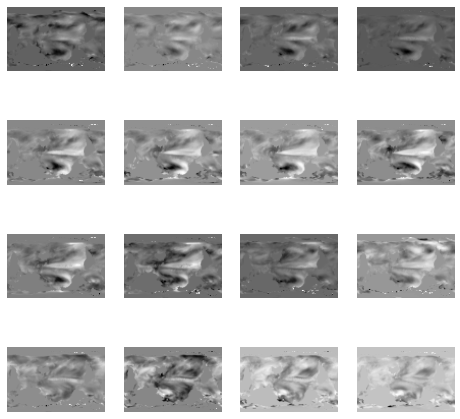

In [8]:
def plot_grid(XX, N):  #def plot_digits(XX, N, title): 
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    for i in range(N):
        for j in range(N):
            ax[i,j].imshow(XX[(N)*i+j,:].reshape((64, 96)), cmap="Greys")
            ax[i,j].axis("off")
            # fig.suptitle(title, fontsize=24)

# plot_digits(X_train, 8, "First 64 Training Features" )
plot_grid(X_train_smaller, 4)

In [9]:
# using sklearn

# --- 
# Pointer: sklearn has functionalities for PCA and Ridge regression with crossvalidation. 
# Using these can make your life much easier.
# --- 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [10]:
X_train = X_train_smaller
X_test = X_test_smaller

Y_train = Y_train_smaller
Y_test = Y_test_smaller

In [11]:
mean_data = np.mean(X_train,0)
centered_X_train = X_train - mean_data

# X_train_standard = StandardScaler().fit_transform(centered_X_train)

pca = PCA(n_components = 100)
pca.fit(centered_X_train) #X_train_standard

components = pca.components_
print(components[:16,:].shape)

(16, 6144)


In [12]:
mean_data = np.mean(X_test,0)
centered_X_test = X_test - mean_data

# X_train_standard = StandardScaler().fit_transform(centered_X_train)

pca_test = PCA(n_components = 100)
pca_test.fit(centered_X_test) #X_train_standard

components_test = pca.components_
print(components_test[:16,:].shape)

(16, 6144)


##### Use PCA to investigate the dimensionality of X_train and plot the first 16 modes

In [13]:
#### Explained variance, explained variance ratio, singular values
# -------------------------------------------
# From documentation:

# explained_variance_ : array, shape (n_components,) The amount 
# of variance explained by each of the selected components.

# explained_variance_ratio_ : array, shape (n_components,) Percentage 
# of variance explained by each of the selected components.

# singular_values_ndarray of shape (n_components,)
# The singular values corresponding to each of the selected components. 
# The singular values are equal to the 2-norms of the n_components 
# variables in the lower-dimensional space.

# -------------------------------------------

nuclear_norm = np.linalg.norm(pca.singular_values_) # is the sum of singular singulars
sv_scaled = pca.singular_values_**2/(nuclear_norm**2) 
# sv_scaled = pca.explained_variance_ratio_
sv_total = np.cumsum(pca.singular_values_**2)/(nuclear_norm**2)

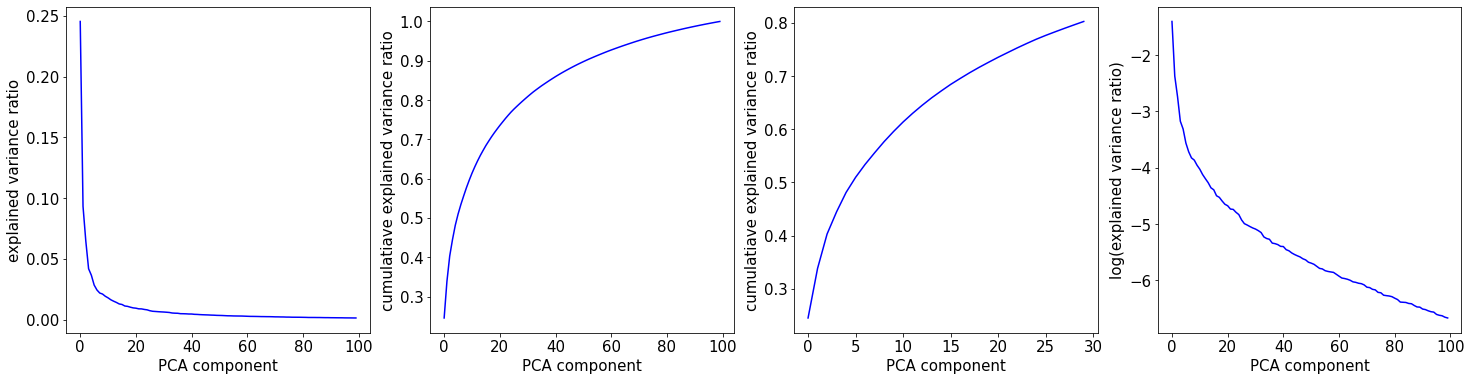

In [14]:
# -- Plot the singular values
plt.rcParams["figure.figsize"] = (25,6)

plt.subplot(1, 4, 1)
plt.plot(sv_scaled, 'blue') # equivalent to pca.explained_variance_ratio_
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('explained variance ratio', fontsize=15)

plt.subplot(1, 4, 2)
plt.plot(sv_total, 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 3)
plt.plot(sv_total[:30], 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 4)
plt.plot(np.log(sv_scaled),'blue') # equivalent to np.log(pca.singular_values_)
# plt.plot(np.log(pca.singular_values_))
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('log(explained variance ratio)', fontsize=15)

plt.show()

##### How many PCA modes do you need to keep in order to approximate X_train up to 60%, 80% and 90% in the Frobenius norm?

In [15]:
pca_total = PCA(n_components=100)
pca_total.fit(X_train)
frobenius_norm = np.sqrt(sum(pca_total.singular_values_**2))

In [16]:
def no_pca_modes(ratio):
    pca_test = PCA(n_components=1)
    pca_test.fit(X_train)
    np.sqrt(sum(pca_test.singular_values_**2))
    i = 1
    while np.sqrt(sum(pca_test.singular_values_**2)) < ratio*frobenius_norm:
        i += 1
        pca_test = PCA(n_components=i)
        pca_test.fit(X_train)
    return i

print('Number of PCA modes to keep to approximate X_train up to 60%: ', no_pca_modes(0.6))
print('Number of PCA modes to keep to approximate X_train up to 80%: ',no_pca_modes(0.8))
# print('Number of PCA modes to keep to approximate X_train up to 90%: ',no_pca_modes(0.9))

Number of PCA modes to keep to approximate X_train up to 60%:  3
Number of PCA modes to keep to approximate X_train up to 80%:  13


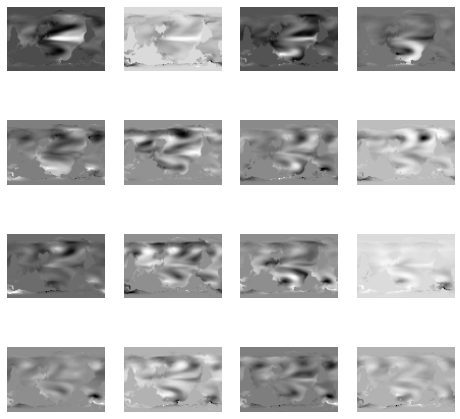

In [17]:
plot_grid(components[:16,:], 4)

In [18]:
print(X_train.shape)

(32400, 6144)


(100, 64, 96)


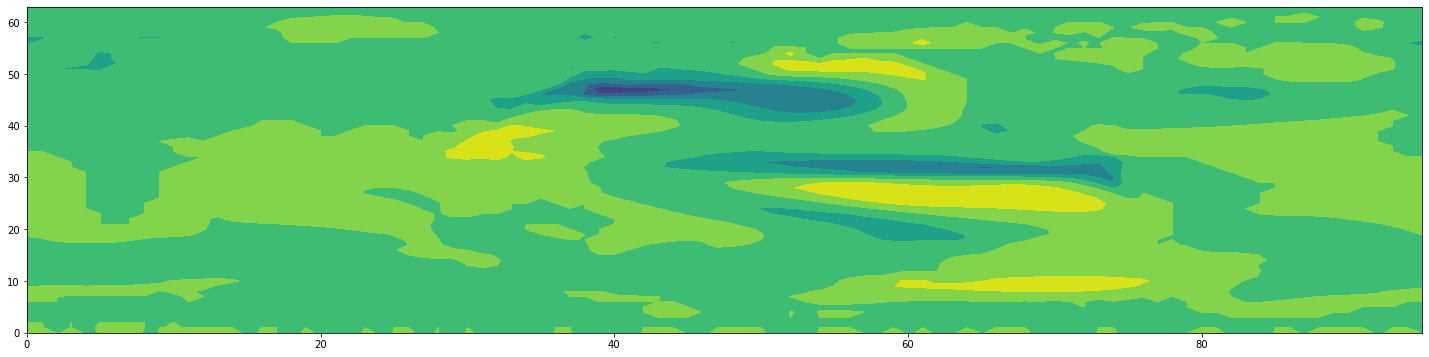

In [19]:
reshape_comp = np.reshape(components, (100,64,96))
print(reshape_comp.shape)
reshape_comp[0,:,:].shape
plt.contourf(reshape_comp[2,:,:])
plt.show()

For any one SST snapshot, we should be able to find coefficient

In [20]:
PCs = pca.transform(X_train)

In [21]:
number_of_PCA_modes = 32

In [22]:
print(PCs[:,0:number_of_PCA_modes].shape)

(32400, 32)


In [23]:
PCs_reshape = np.reshape(PCs[:,0:number_of_PCA_modes], (2700,12,number_of_PCA_modes))

In [24]:
print(PCs_reshape.shape)

(2700, 12, 32)


In [25]:
PCs_test = pca.transform(X_test)
print(PCs_test[:,0:32].shape)
PCs_test_reshape = np.reshape(PCs_test[:,0:number_of_PCA_modes], (300,12,number_of_PCA_modes))
print(PCs_test_reshape.shape)

(3600, 32)
(300, 12, 32)


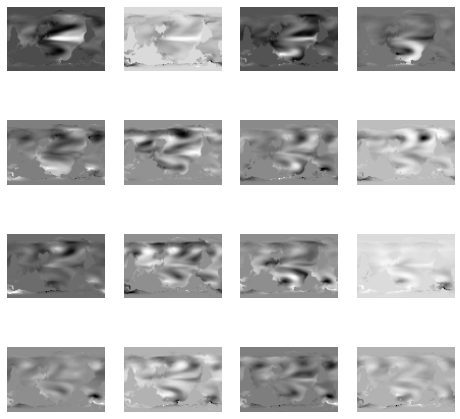

In [26]:
# Check PCA
# - multiple each of the PCA maps by the corresponding coefficients (or do one example) and add it to each other and plot it --> see if it looks like SSTA
plot_grid(components[:number_of_PCA_modes,:], 4)


In [201]:
print(type(components))
saved = np.save('pcacomponents.npy',components)

<class 'numpy.ndarray'>


In [202]:
pcacomponents_ = np.load('pcacomponents.npy', allow_pickle=True)
pcacomponents_

array([[-3.63805825e-21,  1.87466286e-21,  3.23120529e-23, ...,
        -2.91451953e-04, -2.91688798e-04, -2.91967445e-04],
       [-1.09719800e-16,  2.17980048e-17, -4.02816103e-20, ...,
         1.86623512e-03,  1.86975082e-03,  1.87297358e-03],
       [ 9.37809332e-17, -1.40219619e-16,  6.53342160e-18, ...,
        -2.13199968e-04, -2.11398082e-04, -2.09705451e-04],
       ...,
       [ 1.55203722e-17,  3.28130667e-17, -2.99767515e-18, ...,
         5.64183912e-05,  3.35652800e-05,  1.44558413e-05],
       [ 2.39457419e-17, -3.84611132e-17,  3.28764162e-17, ...,
         2.54692635e-04,  2.43401311e-04,  2.31840053e-04],
       [-1.51864115e-17,  9.47288940e-18, -3.10867356e-17, ...,
         1.21409957e-03,  1.23263011e-03,  1.25005754e-03]])

### LSTM

In [27]:
# import deep learning libraries
import tensorflow as tf
from tensorflow import keras

In [28]:
inputs = PCs_reshape
lstm = tf.keras.layers.LSTM(4)

2022-08-19 17:19:00.972956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
output = lstm(inputs)

In [30]:
output.shape

TensorShape([2700, 4])

In [36]:
x = tf.keras.layers.Input((12,number_of_PCA_modes))
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True))(x)
y = tf.keras.layers.Dropout(.5)(y)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True))(y)
y = tf.keras.layers.Dropout(.5)(y)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True))(y)
y = tf.keras.layers.Dropout(.5)(y)
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True))(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.Dropout(.5)(y)
y = tf.keras.layers.LSTM(100, return_sequences=False)(y)
y = tf.keras.layers.Dense(12, activation='linear')(y)

In [37]:
model = tf.keras.models.Model(x,y)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 32)]          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 12, 40)           8480      
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 12, 40)            0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 12, 40)           9760      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 12, 40)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 12, 40)           9760

In [38]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
model.compile(optimizer='adam', loss='MSE', metrics=['MSE'])

In [39]:
hist = model.fit(x = PCs_reshape, y = d_Y_train, epochs=20,validation_data=(PCs_test_reshape,d_Y_test))

Epoch 1/20
85/85 [==============================] - 31s 163ms/step - loss: 1.2727 - MSE: 1.2727 - val_loss: 1.3998 - val_MSE: 1.3998
Epoch 2/20
85/85 [==============================] - 10s 115ms/step - loss: 0.8859 - MSE: 0.8859 - val_loss: 1.1283 - val_MSE: 1.1283
Epoch 3/20
85/85 [==============================] - 10s 113ms/step - loss: 0.7613 - MSE: 0.7613 - val_loss: 0.9148 - val_MSE: 0.9148
Epoch 4/20
85/85 [==============================] - 10s 114ms/step - loss: 0.6589 - MSE: 0.6589 - val_loss: 0.7792 - val_MSE: 0.7792
Epoch 5/20
85/85 [==============================] - 10s 113ms/step - loss: 0.6021 - MSE: 0.6021 - val_loss: 0.7778 - val_MSE: 0.7778
Epoch 6/20
85/85 [==============================] - 10s 122ms/step - loss: 0.5360 - MSE: 0.5360 - val_loss: 0.8336 - val_MSE: 0.8336
Epoch 7/20
85/85 [==============================] - 10s 113ms/step - loss: 0.5263 - MSE: 0.5263 - val_loss: 0.7901 - val_MSE: 0.7901
Epoch 8/20
85/85 [==============================] - 10s 114ms/step - 

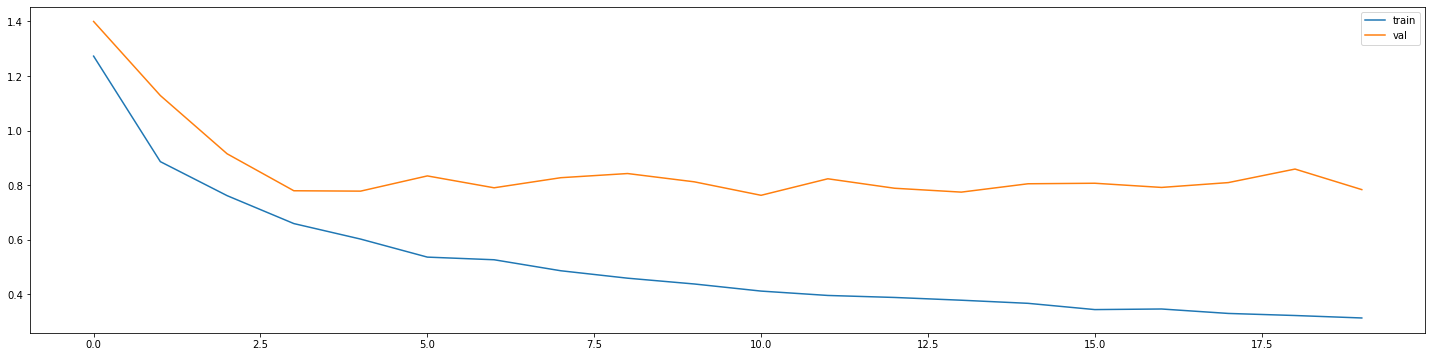

In [40]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.show()

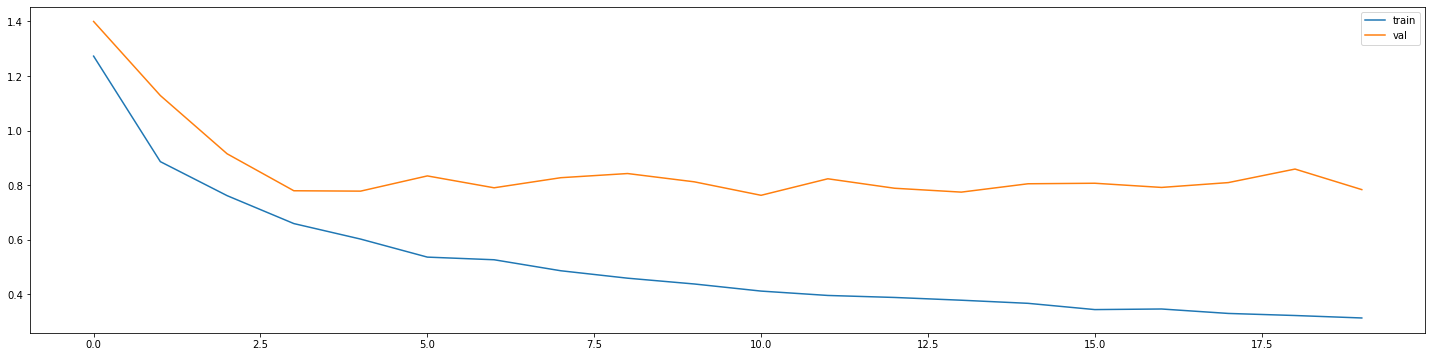

In [41]:
plt.plot(hist.history['MSE'], label='train')
plt.plot(hist.history['val_MSE'], label='val')
plt.legend()
plt.show()

In [42]:
predictions = model.predict(PCs_reshape)

85/85 [==============================] - 6s 29ms/step


In [43]:
predictions.shape

(2700, 12)

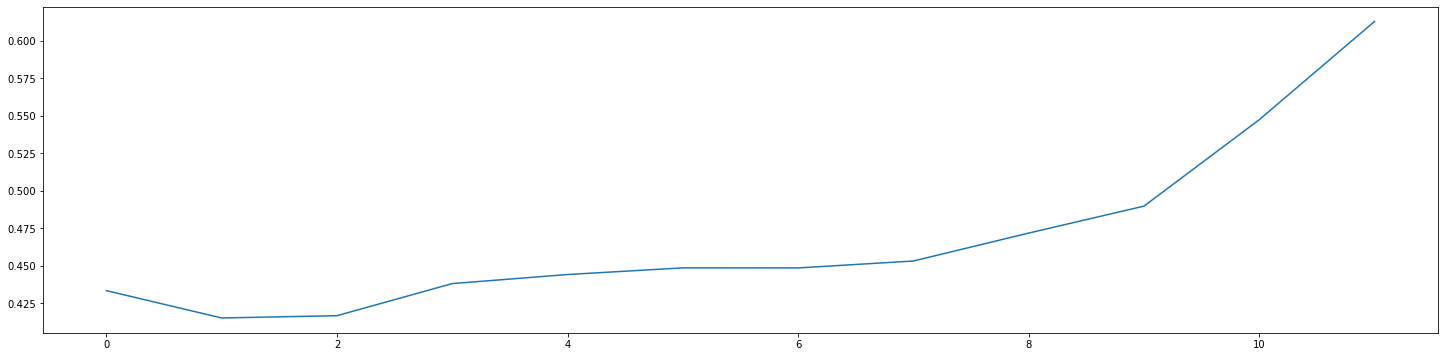

In [44]:
plt.plot((np.mean((predictions-d_Y_train)**2, axis=0))**(1/2))
plt.show()

In [45]:
predictions_test = model.predict(PCs_test_reshape)

10/10 [==============================] - 0s 26ms/step


In [46]:
(np.mean((predictions-d_Y_train)**2,axis=0)**(1/2))

array([0.43343198, 0.4151972 , 0.4167179 , 0.43811998, 0.44416468,
       0.44860255, 0.44854876, 0.4531757 , 0.47179582, 0.48976063,
       0.54737449, 0.61287705])

In [47]:
(np.mean((predictions_test-d_Y_test)**2, axis=0)**(1/2))

array([0.59542728, 0.63305725, 0.70579251, 0.77741579, 0.83489115,
       0.8785725 , 0.94108296, 0.97304017, 0.99493547, 1.01291434,
       1.04218603, 1.06761024])

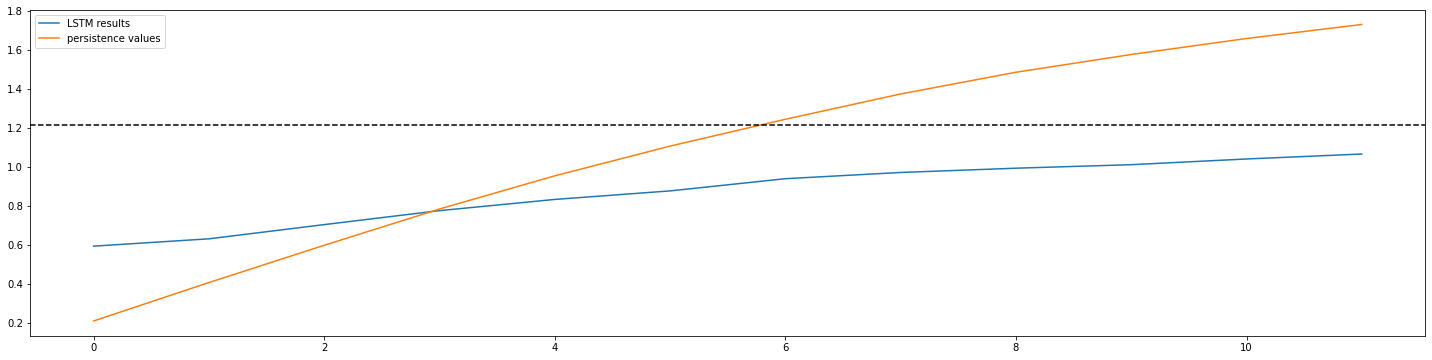

In [48]:
plt.plot((np.mean((predictions_test-d_Y_test)**2, axis=0))**(1/2),label='LSTM results')
# plot baseline
plt.plot([0,1,2,3,4,5,6,7,8,9,10,11], [0.21198327, 0.40898518, 0.59985655, 0.78577634, 0.95578795, 1.10812402,1.24568519, 1.37530367, 1.48666564, 1.57766185, 1.65953142, 1.73153082],label='persistence values')
plt.axhline(y=1.217, color='k', linestyle='--')
plt.legend()
plt.show()

In [49]:
print((np.mean((predictions_test-d_Y_test)**2, axis=0))**(1/2))

[0.59542728 0.63305725 0.70579251 0.77741579 0.83489115 0.8785725
 0.94108296 0.97304017 0.99493547 1.01291434 1.04218603 1.06761024]


In [50]:
PCs_reshape.shape

(2700, 12, 32)

In [ ]:
plt.plot(PCs_reshape[0,:,0])